HPA_AS
24.16000030517578 21.15000030517578
47 番目で終わり
RV_ [24.092680126421957, 24.38060382543093, 24.64526120524004]
HFA_AS_c0
24.16000030517578 21.50000030517578
34 番目で終わり
RV_0 [27.102372392832393, 30.10122471543565, 31.55657602610397]
HPA_KF
24.16000030517578 21.15000030517578
47 番目で終わり
RV_ [24.092680126421957, 24.38060382543093, 24.64526120524004]
HFA_KF_c0
24.16000030517578 21.190000305175783
205 番目で終わり
RV_0 [24.765540090840044, 27.588465996483716, 28.86932075171231]
HPA_YS
24.16000030517578 21.15000030517578
47 番目で終わり
RV_ [24.092680126421957, 24.38060382543093, 24.64526120524004]
HFA_YS_c0
24.16000030517578 20.550000305175782
25 番目で終わり
RV_0 [24.189782000833244, 24.31490384983689, 24.77062662109722]


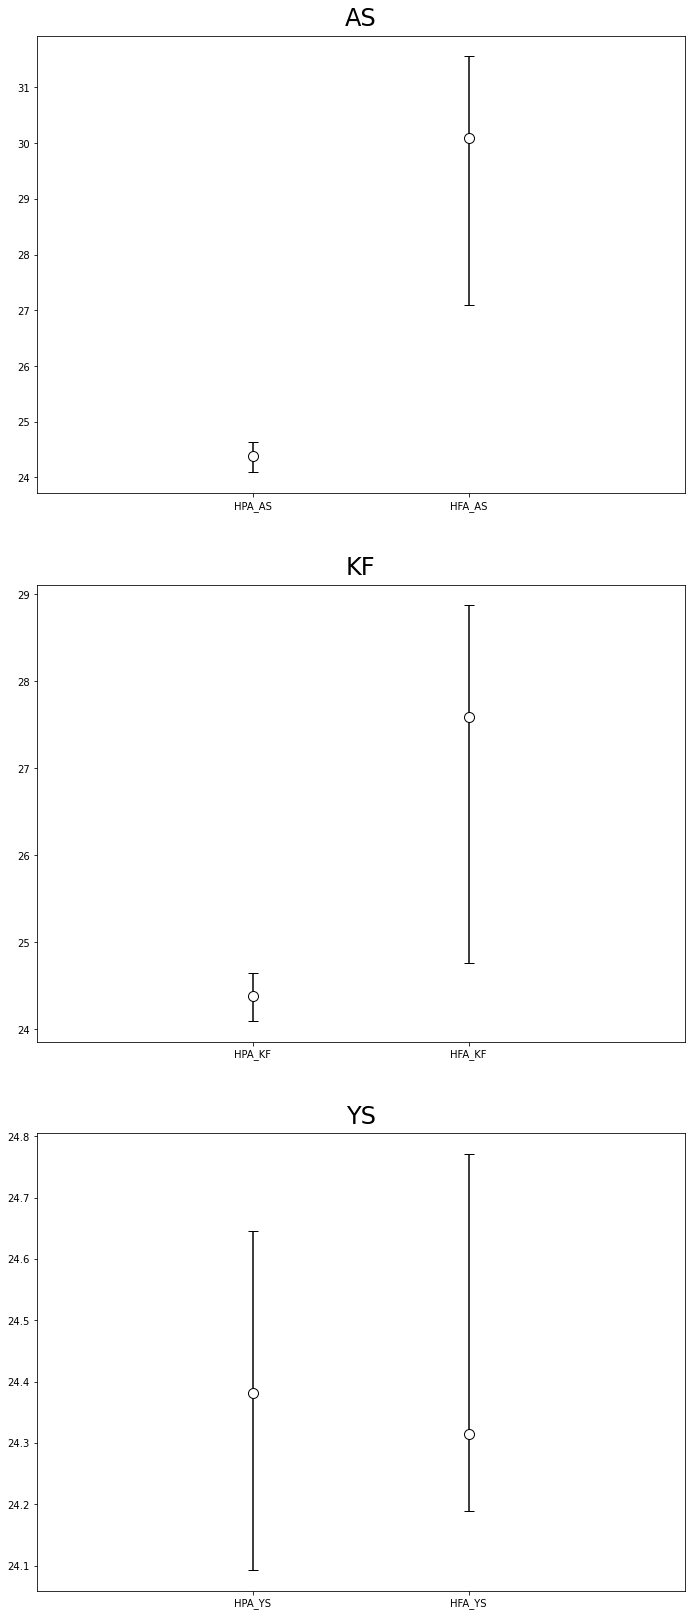

In [1]:
from csv import reader
import matplotlib.pyplot as plt
import numpy as np
import func

fig = plt.figure(figsize=(10, 24))

MODEL = ['AS', 'KF', 'YS']

for model_num in range(3):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'
        
        print(model)

        with open('../pot_csv/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0
        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[1] == 24.170000305175783:  #この値は欠損地扱い
                continue
            if data[0] > last_index + 24 * 7:
                EVENT_POT.append([data[0], data[1]])
                last_index = data[0]
                max_val = data[1]
            else:
                if data[1] > max_val:
                    EVENT_POT[-1] = [data[0], data[1]]
                    last_index = data[0]
                    max_val = data[1]

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(pot[1])
        
        # 大きい順にsort
        POT_DATA.sort(reverse=True)
        POT_DATA = POT_DATA[:100]
        print(POT_DATA[0], POT_DATA[-1])
        
        if num == 0:
            RV_ = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=50, con=0.95)
            print('RV_', RV_)
        else:
            RV_0 = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143, n0=50, con=0.95)
            print('RV_0', RV_0)


    # 描画
    ax = fig.add_subplot(3, 1, model_num + 1)
    a = plt.errorbar(
        x=[1, 2],
        y=[RV_[1], RV_0[1]],
        yerr=np.array(
            [
                [RV_[1] - RV_[0], RV_0[1] - RV_0[0]],
                [RV_[2] - RV_[1], RV_0[2] - RV_0[1]]
            ]
        ),
        capsize=5,
        fmt='o',
        markersize=10,
        ecolor='black',
        markeredgecolor='black',
        color='w'
    )
    ax.set_xlim((0, 3))
    ax.set_title(model[4:6], fontsize=24, pad=10)
    ax.set_xticks([1, 2], ['HPA_' + model[4:6], 'HFA_' + model[4:6]])

plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)
plt.savefig("../img/rv_of_tc.png")
plt.show()